In [11]:
!pip install torch===1.2.0 torchvision===0.4.0 

In [12]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 552, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 552 (delta 36), reused 61 (delta 31), pack-reused 479
Receiving objects: 100% (552/552), 17.80 MiB | 23.43 MiB/s, done.
Resolving deltas: 100% (295/295), done.


In [13]:
cd pytorch_advanced/2_objectdetection

/content/pytorch_advanced/2_objectdetection/pytorch_advanced/2_objectdetection


In [14]:
import os
import urllib.request
import zipfile
import tarfile

In [15]:
# 폴더 "data"가 존재하지 않으면 생성
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [16]:
# 폴더 "weights"가 존재하지 않으면 생성
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [17]:
# VOC2012 데이터 셋 다운로드
# 약 15분 소요
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)  # tar 파일 로드
    tar.extractall(data_dir)   #tar 파일 압축 해제
    tar.close() 


In [18]:
# 학습된 SSD용 VGG 파라미터를 폴더 "weights"로 다운로드
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch
    
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join(weights_dir, "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [19]:
# 학습된 SSD용 VGG 파라미터를 폴더 "weights"로 다운로드
# MIT License
# Copyright (c) 2017 Max deGroot, Ellis Brown
# https://github.com/amdegroot/ssd.pytorch

url = "https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth"
target_path = os.path.join(weights_dir, "ssd300_mAP_77.43_v2.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

# object detction - SSD
`obejct detection` 이란 한 장의 사진에 포함된 여러 물체에 대해 영역과 이름을 확인하는 작업입니다. 아래 이미지는 object detection의 결과 입니다. 
![](https://lambdalabs.com/blog/content/images/2019/02/detect2-1.jpg)  
사람과 야구 방망이에 각각 테두리가 표시되어 있습니다. 물체의 위치를 나타내는 테두리를 bounding box라고 하고, 테두리의 왼쪽 상단에는 라벨명이 나오며 숫자가 함께 출력 됩니다.  
숫자는 해당 라벨의 정확도(신뢰도)를 의미 합니다.

---
SSD를 활용한 object detectiond의 순서는 다음과 같습니다. 
해당 순서는 SSD300의 경우 입니다. 

1. 300 x 300으로 이미지 resize
    - 픽셀을 300 X 300 으로 리사이즈하고 색 정보의 표준화 적용
2. 디폴트 박스 8,732개 준비
    - 다양한 크기 및 비율의 디폴트 박스를 준비
    - SSD는 8,732개의 디폴트 박스를 준비
3. SSD 네트워크에 이미지 입력
    - 전처리한 이미지를 SSD에 입력. 8,732개의 각 디폴트 박스를 바운딩 박스로 수정하는 오프셋 정보 4변수와 디폴트 박스가 각 클래스의 물체인 신뢰도 21개의 합계 8,732 * (4+21) = 218,300 개의 정보를 출력한다
    - 여기서 21은 타겟 LABEL의 종류가 21이라 그런거다.

4. 신뢰도 높은 디폴트 박스 추출
    - 8,732개의 디폴트 박스 중 신뢰도 높은 것을 상위에서 TOP_K(SSD300에서느 200)추출
    - 디폴트 박스에 대응하는 레벨은 그중에서도 신뢰도가 가장 높은 클래스
5. 오프셋 정보로 수정 및 중복 제거
    - 오프셋 정보를 사용하여 디폴트 박스를 바운딩 박스로 변형. 4번째 단계에서 꺼낸 TOK_k개의 디폴트 박스 중 바운딩 박스와 겹치는 것(같은 물체를 감지한 것으로 보이는)이 많ㄴ 다면 가장 신뢰도 높은 바운딩 박스만 남김
6. 일정 신뢰도 이상을 최종 출력으로 선정
    - 최종 바운딩 박스와 라벨 출력. 신뢰도의 임계치를 결정하여 그 이상의 신뢰도를 가진 바운딩 박스만 최종적으로 출력.


## object detection의 입력과 출력
object detection의 입력은 이미지 입니다. 출력은 다음과 같습니다. 
- 이미지 어디에 물체가 존재하는지 나타내는 바운딩 박스의 위치와 크기 정보
- 각 바운딩 박스가 어떤 물체인지 나타내는 라벨 정보
- 라벨의 신뢰도

SSD 알고리즘은 `바운딩 박스 중심의 좌표(cx, cy)`와 바운딩 박스의 너비 w, 바운딩 박스의 높이 h로 바운딩 박스를 표현 합니다.  
또한 라벨 정보는 감지하려는 물체의 클래스 수 X에 어떠한 물체도 아닌 배경 클래스(background)를 더해 총 X+1 종류의 클래스로 각 바운딩 박스당 하나의 라벨을 구합니다.  

라벨의 신뢰도는 각 바운딩 박스와 라벨에 대한 신뢰도를 보여줍니다. 물체 감지는 신뢰도가 높은 바운딩 박스만 최종 출력합니다. 


In [20]:
# 라이브러리import
import os.path as osp
import random

import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

%matplotlib inline

In [21]:
# 랜덤 시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [22]:
# 학습 및 검증용 이미지 데이터, 어노테이션 데이터의 파일 경로 리스트 작성

def make_datapath_list(rootpath):
    """
    데이터 경로를 저장한 리스트 생성

    파라미터
    ---
    rootpath : str
        데이터 폴더 경로
    
    returns
    ---
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로를 저장한 리스트
    """
    

    # 이미지 데이터와 어노테이션 파일의 경로 템플릿 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'Annotations', '%s.xml')

    # 학습 및 검증 파일 ID 휙득
    train_id_names = osp.join(rootpath + 'ImageSets/Main/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Main/val.txt')

    # 학습 데이터의 이미지 파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 이미지 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        train_img_list.append(img_path)  # 리스트에 추가
        train_anno_list.append(anno_path)  # 리스트에 추가

    # 검증 데이터의 이미지 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 이미지 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        val_img_list.append(img_path)  # 리스트에 추가
        val_anno_list.append(anno_path)  # 리스트에 추가

    return train_img_list, train_anno_list, val_img_list, val_anno_list

In [23]:
# 파일 경로 리스트 작성
rootpath = './data/VOCdevkit/VOC2012/'
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath)

print(train_img_list[0])

./data/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg


In [24]:
# XML 형식의 어노테이션을 리스트 형식으로 변환하는 클래스

class Anno_xml2list(object):
    """
    한 이미지의 XM 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환

    attributes
    ---
    classes : 리스트
        VOC의 클래스명을 저장한 리스트
    
    """

    def __init__(self, classes):

        self.classes = classes

    def __call__(self, xml_path, width, height):
        """
        한 화상의 XML 형식 어노테이션 데이터를 화상 크기로 규격화하여 리스트 형식으로 변환 

        파라미터
        ----------
        xml_path : str
            xml 파일 경로
        width : int
            대상 화상 폭
        height : int
            대상 화상 높이

        Returns
        -------
        ret : [[xmin, ymin, xmax, ymax, label_ind], ... ]
            물체의 어노테이션 데이터를 저장한 리스트. 화상에 존재하는 물체 수만큼의 요소를 가진다.
        """

        # 화상 내 모든 물체의 어노테이션을 이 리스트에 저장
        ret = []

        # xml 파일 로드
        xml = ET.parse(xml_path).getroot()

        # 이미지 내 object 수만큼 반복
        for obj in xml.iter('object'):

            # 어노테이션에서 검지가 difficult로 설정된 것은 제외
            difficult = int(obj.find('difficult').text)
            if difficult == 1:
                continue

            # 한 물체의 어노테이션을 저장하는 리스트
            bndbox = []

            name = obj.find('name').text.lower().strip()  #  물체 이름
            bbox = obj.find('bndbox')  # 바운딩 박스 정보

            # 어노테이션의 xmin, ymin, xmax, ymax를 취득하고 0~1로 정규화
            pts = ['xmin', 'ymin', 'xmax', 'ymax']

            for pt in (pts):
                # VOC데이터는 원점이 (1,1) 이므로 1을 빼서 (0,0) 변환한다.
                cur_pixel = int(bbox.find(pt).text) - 1

                # 폭, 높이로 규격화
                if pt == 'xmin' or pt == 'xmax':  # x 방향의 경우 폭으로 나눈다.
                    cur_pixel /= width
                else:  # y 방향의 경우 높이로 나눈다.
                    cur_pixel /= height

                bndbox.append(cur_pixel)

            # 어노테이션 클래스명 index를 츼득하여 추가
            label_idx = self.classes.index(name)
            bndbox.append(label_idx)

            #  res에 [xmin, ymin, xmax, label_ind]를 더한다
            ret += [bndbox]

        return np.array(ret)  # [[xmin, ymin, xmax, ymax, label_ind], ... ]

In [25]:
# 동작 확인
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

transform_anno = Anno_xml2list(voc_classes)

# 화상 로드용으로 OpenCV tkdyd
ind = 1
image_file_path = val_img_list[ind]
img = cv2.imread(image_file_path)  # 높이/폭/색RGB
height, width, channels = img.shape  # 이미지 shape

# 어노테이션을 리스트로 표시
transform_anno(val_anno_list[ind], width, height)

array([[ 0.09      ,  0.03003003,  0.998     ,  0.996997  , 18.        ],
       [ 0.122     ,  0.56756757,  0.164     ,  0.72672673, 14.        ]])

## 이미지와 어노테이션의 전처리를 실행하는 DataTransform 클래스 작성
- 데이터 transform 적용 시 이미지를 확장하는데, 그때 BBox정보를 동시에 변형해야 된다. 

- 이미지 데이터를 불러올 떄 OpenCV를 사용하는데 OpenCv로 이미지를 불러올때는 `높이/폭/색상(BGR)`순으로 불러온다. 색상 채널이 RGB가 아닌 BGR로 이미지를 불러온다.

In [26]:

# 입력 이미지의 전처리 클래스
from utils.data_augumentation import Compose, ConvertFromInts, ToAbsoluteCoords, PhotometricDistort, Expand, RandomSampleCrop, RandomMirror, ToPercentCoords, Resize, SubtractMeans

class DataTransform():
    """
    이미지와 어노테이션의 전처리 클래스. 학습과 추론에서 다르게 작동한다.
    이미지 크기를 300x300으로 한다.
    학습 시에만 데이터의 이미지를 확장한다.

    attributes
    ---
    input_size : int
        리사이즈 대상 화상의 크기
    color_mean : (B, G, R)
        각 색상 채널의 평균 값
    """

    def __init__(self, input_size, color_mean):
        self.data_transform = {
            'train': Compose([
                ConvertFromInts(),  # int를 float32로 변환
                ToAbsoluteCoords(),  # 어노테이션 데이터의 규격화 반환
                PhotometricDistort(),  # 이미지의 색조 등 임의의 변화
                Expand(color_mean),  # 이미지의 캔버스 확대
                RandomSampleCrop(),  # 이미지내의 특정 부분 무작위 추출
                RandomMirror(),  # 이미지 반전
                ToPercentCoords(),  # 어노테이션 데이터를 0~1로 규격화
                Resize(input_size),  # 이미지 크기를 input_size x input_size로 변형
                SubtractMeans(color_mean)  # BGR 색상의 평균값 빼기
            ]),
            'val': Compose([
                ConvertFromInts(),  # int를 float으로 변환
                Resize(input_size),  # 화상 크기를 input_size x input_size로 변환
                SubtractMeans(color_mean)  # BGR 색상의 평균값 빼기
            ])
        }

    def __call__(self, img, phase, boxes, labels):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정
        """
        return self.data_transform[phase](img, boxes, labels)

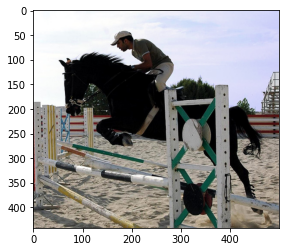

/content/pytorch_advanced/2_objectdetection/utils/data_augumentation.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mode = random.choice(self.sample_options)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


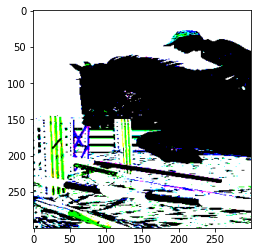

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


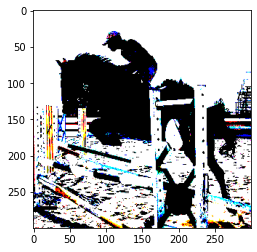

In [27]:
# 동작 확인 

# 1. 이미지 읽기
image_file_path = train_img_list[0]
img = cv2.imread(image_file_path)  # [높이/폭/색BGR]
height, width, channels = img.shape  # 이미지 크기 휙득

# 2. 어노테이션을 리스트로
transform_anno = Anno_xml2list(voc_classes)
anno_list = transform_anno(train_anno_list[0], width, height)

# 3. 원본 표시
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 4. 전처리 클래스 작성
color_mean = (104, 117, 123)  # BGR 색상의 평균 값
input_size = 300  # 화상의 input 사이즈를 300 x 300 으로
transform = DataTransform(input_size, color_mean)

# 5. train 이미지 변환 후 출력
phase = "train"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()


# 6. val 이미지 변환 후 출력
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4])
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

## dataset 작성

In [28]:
# VOC2012のDatasetを作成する


class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. 파이토치의 Dataset 클래스를 상속한다.

    Attributes
    ---
    img_list : 리스트
        이미지 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 겨ㅇ로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스의 인스턴스
    transform_anno : object
        xml 어노테이션을 리스트로 변환하는 인스턴스

    """

    def __init__(self, img_list, anno_list, phase, transform, transform_anno):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase  # train or val
        self.transform = transform  # 이미지 변환
        self.transform_anno = transform_anno  # 어노테이션 데이터를 xml에서 리스트로 변경

    def __len__(self):
        '''이미지 갯수 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리된 이미지의 텐서 형식 데이터와 어노테이션 반환
        '''
        im, gt, h, w = self.pull_item(index)
        return im, gt

    def pull_item(self, index):
        '''전처리한 이미지의 텐서 형식 데이터, 어노테이션, 이미지 높이, 폭 반환'''

        # 1. 이미지 로딩
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # 높이/넓이/색BGR
        height, width, channels = img.shape  # 이미지 shape

        # 2. xml 형식의 어노테이션 정보를 리스트에 저장
        anno_file_path = self.anno_list[index]
        anno_list = self.transform_anno(anno_file_path, width, height)

        # 3. 전처리 실시
        img, boxes, labels = self.transform(
            img, self.phase, anno_list[:, :4], anno_list[:, 4])

        # 색상 채널의 순서가 BGR이므로 RGB로 변경
        # 높이/ 폭/ 색상채널의 순서를 색상채널/높이/폭으로 변경
        img = torch.from_numpy(img[:, :, (2, 1, 0)]).permute(2, 0, 1)

        # BBox와 라벨을 세트로 한 np.array를 생성. 변수 이름 gt는 ground truth의 약칭
        gt = np.hstack((boxes, np.expand_dims(labels, axis=1)))

        return img, gt, height, width

In [29]:
# 데이터셋 작동 확인
color_mean = (104, 117, 123)  # (BGR)의 색의 평균값
input_size = 300  # 이미지 input 사이즈를 300x300으로 한다.

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=Anno_xml2list(voc_classes))


# 이미지 출력 예시
val_dataset.__getitem__(1)

(tensor([[[   0.9417,    6.1650,   11.1283,  ...,  -22.9082,  -13.2200,
             -9.4034],
          [   6.4367,    9.6600,   13.8283,  ...,  -21.4433,  -18.6500,
            -18.2033],
          [  10.8833,   13.5500,   16.7000,  ...,  -20.9917,  -24.5250,
            -25.1917],
          ...,
          [ -23.9501,  -14.9000,   -1.7583,  ..., -108.6083, -111.0000,
           -117.8083],
          [ -28.2816,  -20.1750,   -5.5633,  ..., -104.9934, -111.8350,
           -119.0000],
          [ -20.4766,  -21.0000,  -12.6334,  ..., -107.1685, -115.7800,
           -117.1100]],
 
         [[  25.9417,   30.1650,   35.1283,  ...,  -18.0766,  -14.7250,
            -11.8534],
          [  31.4367,   33.6600,   37.8283,  ...,  -13.5016,  -10.8250,
            -10.3783],
          [  35.7917,   37.5500,   40.7000,  ...,  -11.8417,  -13.0750,
            -14.0167],
          ...,
          [  -1.9501,    7.1000,   20.2417,  ..., -101.9083, -102.0000,
           -109.7167],
          [  -6.2

## DataLoader 구현
--- 
object detection에서는 Dataloader를 조금 다르게 선언해야 한다.  
이미지 데이터마다 dataset에서 꺼낼 어노테이션 데이터 정보, gt 변수의 크기(화상 내의 물체 수)가 다르다. gt는 리스트형 변수이고 요소 수는 이미지 속 물체 수 이다. 각 요소는다섯 개의 변수 [xmin, ymin, xmax, ymax, class_index] 이다.   
dataset에서 꺼내는 변수의 크기가 데이터마다 다르다면 DataLoader 클래스에서 기본적으로 사용하는 데이터 추출 함수인 collate_fn을 별도로 만들어야 한다. 

In [30]:
def od_collate_fn(batch):
    """
    dataset에서 꺼내는 어노테이션 데이터의 크기는 이미지마다 다르다.
    이미지 내의 물체 수가 두 개이면 (2,5) 사이즈이지만 세 개이면 (3, 5)로 바뀐다.
    변화에 대응하는 DataLoader를 만드는 collate_fn을 작성한다.
    collate_fn은 파이토치 리스토로 mini-batch를 작성하는 함수이다. 
    미니 배치 분량의 화상이 나열된 리스트 변수 batch에 미니 배치 번호를 지정하는 차원을
    가장 앞에 하나 추가하여 리스트 형태로 변형한다.
    """

    targets = []
    imgs = []
    for sample in batch:
        imgs.append(sample[0]) # sample[0]는 이미지
        targets.append(torch.FloatTensor(sample[1])) # sample[1]은 어노테이션 gt
    
    # imgs는 미니 배치 크기의 리스트
    # 리스트 요소는 torch.Size([3, 300, 300])
    # 이 리스트를 torch.Size([batch_num,3,300,300])의 텐서로 변환
    imgs = torch.stack(imgs, dim = 0)

    # tragets는 어노테이션의 정답인 gt 리스트
    # 리스트 크기 = 미니 배치 크기
    # targets 리스트의 요소는 [n,5]
    # n은 이미지 마다 다르며 이미지 속 물체의 수
    # 5는 [xmin, ymin, xmax, ymax, class_index]

    return imgs, targets

In [31]:
# 데이터 로더 작성

batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# dict 형식으로 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"])  
images, targets = next(batch_iterator)  # 첫 번째 요소 추출
print(images.size())  # torch.Size([4, 3, 300, 300])
print(len(targets))
print(targets[1].size())  # 미니 배치 크기의 리스트, 각 요소는 [n,5], n은 물체 수

torch.Size([4, 3, 300, 300])
4
torch.Size([2, 5])


# 네트워크 모델 구현
- SSD 모델의 입력은 전처리된 이미지 데이터 이며 크기는 300 x 300 pixel 이다. 
- SSD 모델의 출력은 8,732개의 DBox에 대한 오프셋 정보와 각 클래스에 대한 21 종류의 신뢰도 이다.
- SSD의 주요 서브 네트워크는 vgg, extra, loc, conf 네 가지이다.
### vgg 
- vgg 모듈에서 10회의 합성곱을 거친 데이터는 별도로 추출하여 `L2Norm`층에서 크기를 정규화 한 후 변수 `source1`로 사용
- vgg 모듈에서 15회의 합성곱을 받은 데이터는 변수 `source2`로 사용
- source1은 채널 수 512, 특징량 맵 크기는 38 x 38 
- source2는 채널 수 512, 특징량 맵 크기는 19 x 19

### extra
- extar 모듈은 max-pooling을 사용하지 않고 합성곱 처리를 총 8회 실시
- 2회 합성마다 나오는 출력값을 sorce3~6으로 사용 
- 각 source의 특징량 맵 크기는 각각 10x10, 5x5, 3x3, 1x1
-이 처럼 특징량 맵 크기가 서로 다른 source1~6을 이용하여 이미지 속 다양한 크기의 물체를 상정한 특징량을 얻을 수 있다. 

### loc
- vgg모듈과 extra 모듈로 source 1~6까지 특징량 맵 크기가 서로 다른 여섯 개의 소스를 얻은 다음 해당 소스를 loc 모듈로 각 소스에 1회씩 합성곱 처리를 실행하여 총 8,732개의 DBox의 오프셋 정보를 출력

### conf
- conf도 마찬가지로 1~6까지 각 소스에 합성곱 처리를 실시하여 8,732개 DBox의 20가지 +배경 총 21가지 클래스의 신뢰도 출력



## vgg 모듈 구현
- 각 합성곱 층의 채널 수와 최대 풀링 층의 정보를 구성 변수로 하여 cfg = [64, 64, 'M', ...]로 작성하고 그 요소의 값에 따라 유닛을 만든다.
- cfg의 요소 'M'은 최대 풀링층을, 'MC'는 ceil 모드의 최대 풀링층.
- 기본적으로 max pooling층의 출력 텐서 크기를 계산할 때는 follor 모드가 되어 정수 텐서 그기를 구할 때 소수점을버린다. 하지만 ceil모드로 하면 소수점을 올린다. 
- ReLU 인수 inplace는 ReLU에 대한 입력을 메모리 상에 유지할 것인지 혹은 입력을 재작성 하여 출력으로 바꾼 후 메모리 상에 유지하지 않을 것인지 나타낸다. 

In [32]:
 from math import sqrt
from itertools import product

import pandas as pd
import torch
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [33]:
# 34층에 걸친 vgg 모듈 작성
def make_vgg():
    layers = []
    in_channels = 3  # 색 채널 수

    # vgg 모듈에서 사용하는 합성곱 층이나 최대 풀링 채널 수
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256,
           256, 'MC', 512, 512, 512, 'M', 512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceil은 계산 결과에서 출력 크기의 소수점을 올려 정수로 하는 모드
            # 디폴트는 계산 결과에서 출력 크기의 소수점을 버려 정수로 하는 floor 모드
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6,
               nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)


# 동작확인
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

## extra

In [34]:
# 8개의 층으로 이뤄진 extras 모듈 작성

def make_extras():
    layers = []
    in_channels = 1024  # vgg 모듈에서 출력된 extra에 입력되는 이미지 채널 수

    # extra 모듈의 합성곱 층 채널 수를 설정하는 구성
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]
    
    # 활성화 함수의 relu는 나중에 구현
    

    return nn.ModuleList(layers)


# 확인
extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


## loc 및 conf 모듈 구현
- loc와 conf 모듈은 각각 여섯 개의 합성곱 층을 준비하여 하나의 모듈로 합니다. 

In [35]:
#  디폴트 박스의 오프셋을 출력하는 loc_layers와
# 디폴트 박스의 각 클래스 신뢰도 confidence를 출력하는 conf_layers 작성

def make_loc_conf(num_classes=21, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):

    loc_layers = []
    conf_layers = []

    # VGG 22층, conv4_3(source1)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * num_classes, kernel_size=3, padding=1)]

    # VGG 최종층(source2)의 합성곱 층
    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source3)의 합성곱 층
    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source4)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source5)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * num_classes, kernel_size=3, padding=1)]

    # extra(source6)의 합성곱 층
    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * num_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(conf_layers)


# 확인
loc_test, conf_test = make_loc_conf()
print(loc_test)
print(conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 126, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 84, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


- 

## L2Norm층 구현 
 - source1을 생성하는데 적용하는 L2Norm층 구현
 - L2Nrom층에서는 정규화한 512 채널 x 38 x 38 텐서에 각 채널 계수를 곱합니다. 512개의 계수는 학습할 파라미터입니다.

In [36]:
# Conv_4_3의 출력을 scale = 20의 L2Norm으로 정규화 하는 층
class L2Norm(nn.Module):
    def __init__(self, input_channels=512, scale=20):
        super(L2Norm, self).__init__()  # 부모 클래스의 생성자 실행
        self.weight = nn.Parameter(torch.Tensor(input_channels))
        self.scale = scale  # 계수 weighet의 초깃값으로 설정할 값
        self.reset_parameters()  # 파라미터 초기화
        self.eps = 1e-10

    def reset_parameters(self):
        '''결합 파라미터의 scale 크기 값으로 초기화 실행'''
        init.constant_(self.weight, self.scale)  # weight값이 모두 scale(=20)이 된다.

    def forward(self, x):
        '''
        38x38의 특징량에 대해 512 채널에 걸쳐 제곱합의 루트를 구했다.
        38x38개의 값을 사용하여 각 특징량을 정규화한 후 계수를 곱하여 계산하는 층
        '''

        # 각 채널의 38x38개 특징량의 채널 방향 제곱합을 계산하고
        # 루트를 구해 나누어 정규화 한다.
        # norm의 텐서 사이즈는 torch.size([batch_num, 1, 38, 38])
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)

        # 계수를 곱한다. 계수는 채널마다 하나로 512개의 계수를 갖는다.
        # self.weight의 텐서 사이즈는 torch.Size([512])로
        # torch.Size([batch_num, 512, 38, 38])까wl qudgudgksek.
        weights = self.weight.unsqueeze(
            0).unsqueeze(2).unsqueeze(3).expand_as(x)
        out = weights * x

        return out

## 디폴트 박스 구현
--- 
- 8,732개의 디폴트 박스를 준비하는 클래스
- source1~6까지 크기가 서로 다른 특징량 맵에 대해 각각 4 또는 6 종류의 DBox를 만든다. DBox 종류는 네 종류 설정일 때 작은 정사각형, 큰 정사각형, 1:2 비율의 직사각형, 2:1 비율의 직사각여이다.
- 여섯 종류일 때는 3:1과 1:3 비율의 직사각형 형태 DBox를 추가로 준비한다.

In [37]:
# 디폴트 박스를 출력하는 클래스

class DBox(object):
    def __init__(self, cfg):
        super(DBox, self).__init__()

        # 초기설정
        self.image_size = cfg['input_size']  # 이미지 크기 300
        # [38, 19, …] 각 소스의 특징량 맵의 크기
        self.feature_maps = cfg['feature_maps']
        self.num_priors = len(cfg["feature_maps"])  # source의 개수  = 6
        self.steps = cfg['steps']  # [8, 16, …] DBox의 픽셀 크기
        
        self.min_sizes = cfg['min_sizes']
        # [30, 60, …] 작은 정사각형의 DBox 픽셀 크기
        
        self.max_sizes = cfg['max_sizes']
        # [60, 111, …] 큰 정사각형의 DBox 픽셀 크기
        
        self.aspect_ratios = cfg['aspect_ratios']  # 정사각형의 DBox 화면비

    def make_dbox_list(self):
        '''DBox작성'''
        mean = []
        # 'feature_maps': [38, 19, 10, 5, 3, 1]
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):  # f까지의 수로 두 쌍의 조합을 작성. 
                # 특징량의 이미지 크기
                # 300 / 'steps': [8, 16, 32, 64, 100, 300],
                f_k = self.image_size / self.steps[k]

                # DBox의 중심 좌표 x,y. 0~1로 정규화 되어 있다.
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k

                # 화면비 1의 작은 DBox[cx,cy,width, height]
                # 'min_sizes': [30, 60, 111, 162, 213, 264]
                s_k = self.min_sizes[k]/self.image_size
                mean += [cx, cy, s_k, s_k]

                # 화면비 1의 큰 DBOX[cx, cy, width, height]
                # 'max_sizes': [60, 111, 162, 213, 264, 315],
                s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]

                # 그 외 화면비의 defbox[cx,cy, width, height]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
                    mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]

        # DBOX를 텐서로 변환 torch.Size([8732, 4])
        output = torch.Tensor(mean).view(-1, 4)

        # DBox가 이미지 밖으로 돌출되는 것을 막기 위해 크기를 최소 0 , 최대 1로 한다.
        output.clamp_(max=1, min=0)

        return output

In [38]:
# 동작확인

# SSD300설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 이미지 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출력할 Box 화면비 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source 이미지 크기
    'steps': [8, 16, 32, 64, 100, 300],  # DBOX 크기 
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DOBX 크기를 정함
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DOBX 크기를 정함 
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# DBox작성
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBOX 출력 학인
pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


## SSD클래스 구현
- 위에서 만든 모듈을 사용하여 SSD 클래스 구현 

In [39]:
# SSD 클래스 작성
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference 지정
        self.num_classes = cfg["num_classes"]  # 클래스 수 21

        # SSD 네트워크 작성
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론 시 Detect 클래스 준비
        if phase == 'inference':
            self.detect = Detect()


# 확인
ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

## SSD 모델의 순전파
-  SSD 에서는 순전파를 위해 새로운 개념인 Non-Maximum Suppression 을 활용

### decode 함수 구현
- SSD 추론 시 순전파 끝에 detect 클래스를 활용하는데
- detect 클래스에서 사용하는 decode 함수와 nm_supression 함수를 구현
- decode 함수는 `Dbox`와 SSD모델에서 구한 오프셋 정보를 사용하여 BBox 좌표 정보를 생성한다.

In [40]:
# 오프셋 정보로 DBox를 Bbox로 변환하는 함수


def decode(loc, dbox_list):
    """
    오프셋 정보로 DBox를 BBox로 변환

    Parameters
    ----------
    loc:  [8732,4]
        SSD 모델로 추론하는 오프셋 정보
    dbox_list: [8732,4]
        DBox 정보

    Returns
    -------
    boxes : [xmin, ymin, xmax, ymax]
        BBox 정보
    """

    # DBox는[cx, cy, width, height]로 저장 되어 있다.
    # loc도[Δcx, Δcy, Δwidth, Δheight]로 저장 되어 있다.

    # 오프셋 정보로 BBox를 구한다.
    boxes = torch.cat((
        dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:],
        dbox_list[:, 2:] * torch.exp(loc[:, 2:] * 0.2)), dim=1)
    # boxes크기는 torch.Size([8732, 4])가 된다.

    # BBox의 좌표 정보를 [cx, cy, width, height]에서[xmin, ymin, xmax, ymax] 변경
    boxes[:, :2] -= boxes[:, 2:] / 2  # 좌표(xmin,ymin)로 변환
    boxes[:, 2:] += boxes[:, :2]  # 좌표(xmax,ymax)로 변환

    return boxes

In [41]:
def nm_suppression(boxes, scores, overlap=0.45, top_k=200):
    """
    Non-Maximum Suppression을 실시하는 함수
    boxes중 겹치는 BBox 삭제

    파라미터
    ---
    boxes : [신뢰도 임곗값(0.01)을 넘은 BBox 수, 4]
        BBox 정보
    scores : [신뢰도 임곗값(0.01)을 넘은 BBox 수]
        conf 정보

    Returns
    ---
    keep : list
        conf의 내림차순으로 nms를 통과한 index 저장
    count : int
        nms를 통과한 BBox 수
    """

    # return 모형 작성
    count = 0
    keep = scores.new(scores.size(0)).zero_().long()
    # keep : torch.Size([신뢰도 임곗값을 넘은 BBox 수]), 요소는 전부 0

    # 각 BBox의 면적 area 계산
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    # boxes 복사. 나중에 BBox 중복도(IOU) 계산 시 모형으로 준비
    tmp_x1 = boxes.new()
    tmp_y1 = boxes.new()
    tmp_x2 = boxes.new()
    tmp_y2 = boxes.new()
    tmp_w = boxes.new()
    tmp_h = boxes.new()

    # score를 오름차순으로 나열
    v, idx = scores.sort(0)

    # 상위 top_k개(200개)의 Bbox index를 꺼낸다(200개가 존재하지 않는 경우도 있다.)
    idx = idx[-top_k:]

    # idx 요소 수가 0이 아닌 한 루프 한다.
    while idx.numel() > 0:
        i = idx[-1]  # conf의 최대 index를 i로

        # keep의 끝에 conf 최대 index 저장
        # 이 index의 BBox와 크게 겹치는 BBox 삭제
        keep[count] = i
        count += 1

        # 마지막 BBox는 루프를 빠져나온다.
        if idx.size(0) == 1:
            break

        # 현재 conf 최대의 index를 keep에 저장했으므로 idx를 하나 감소 시킨다.
        idx = idx[:-1]

        # -------------------
        # 지금 부터 keep에 저장한 BBox와 크게 겹치는 BBox를 추출하여 삭제
        # -------------------
        # 하나 감소시킨 idx까지의 BBox를 out으로 지정한 변수로 작성
        torch.index_select(x1, 0, idx, out=tmp_x1)
        torch.index_select(y1, 0, idx, out=tmp_y1)
        torch.index_select(x2, 0, idx, out=tmp_x2)
        torch.index_select(y2, 0, idx, out=tmp_y2)

        # 모든 BBox를 현재 BBox=index가 i로 서로 겹치는 값까지로 설정(clamp)
        tmp_x1 = torch.clamp(tmp_x1, min=x1[i])
        tmp_y1 = torch.clamp(tmp_y1, min=y1[i])
        tmp_x2 = torch.clamp(tmp_x2, max=x2[i])
        tmp_y2 = torch.clamp(tmp_y2, max=y2[i])

        # w와 h의 텐서 크기를 index 하나 줄인 것으로 한다.
        tmp_w.resize_as_(tmp_x2)
        tmp_h.resize_as_(tmp_y2)

        # clamp한 상태에서 BBox의 폭과 높이를 구한다.
        tmp_w = tmp_x2 - tmp_x1
        tmp_h = tmp_y2 - tmp_y1

        # 폭이나 높이가 음수인 것은 0으로 한다.
        tmp_w = torch.clamp(tmp_w, min=0.0)
        tmp_h = torch.clamp(tmp_h, min=0.0)

        # clamp되 상태의 면적을 구한다.
        inter = tmp_w*tmp_h

        # IoU = intersect부분 / (area(a) + area(b) - intersect부분) 계산
        rem_areas = torch.index_select(area, 0, idx)  # 가 BBox의 원래 면적
        union = (rem_areas - inter) + area[i]  # 두 구역의 합(OR) 면적
        IoU = inter/union

        # IoU가 overlap 보다 작은 idx만 남긴다
        idx = idx[IoU.le(overlap)]  # le는 Less than or equal to 처리를 하는 연산
        # Iou가 overlap보다 큰 idx는 처음 선택한 keep에 저장한 idx와 동일한 물체에 BBox를 둘러싸고 있어 삭제

    # while 루프에서 빠져나오면 종료

    return keep, count

## Detect 클래스 구현
- Detect 클래스 입력값
    - loc 모듈의 출력, conf 모듈의 출력, 디폴트 박스 정보
- Detect 순전파 순서
    1. decode 함수를 이용하여 loc를 BBox로 변환
    2. conf가 임곗값 이상인 BBox 추출
    3. Non-Maximum Suppression을 적용하여 중복된 박스 제거

In [42]:
# SSD 추론 시 conf와 loc의 출력에서 중복을 제거한 BBox 출력 

class Detect(Function):

    def __init__(self, conf_thresh=0.01, top_k=200, nms_thresh=0.45):
        self.softmax = nn.Softmax(dim=-1)  # conf를 소프트 맥스 함수로 정규화 하기 위해 준비
        self.conf_thresh = conf_thresh  # conf가conf_thresh=0.01보다 높은 DBox만 취급
        self.top_k = top_k  # conf가 높은 tok_k개를 nm_supression으로 계산에 사용하는 top_k = 200
        self.nms_thresh = nms_thresh  # nm_supressiondm로 IOU가 nms_thresh = 0.45 보다 크면 동일한 물체의 BBox로 간주
    
    
    def forward(self, loc_data, conf_data, dbox_list):
        """
        순전파 계산 실행

        Parameters
        ----------
        loc_data:  [batch_num,8732,4]
            오프셋 정보
        conf_data: [batch_num, 8732,num_classes]
            감지 신뢰도
        dbox_list: [8732,4]
            DBox 정보

        Returns
        -------
        output : torch.Size([batch_num, 21, 200, 5])
            （batch_num、클래스、conf의 top200、BBox의 정보）
        """

        # 각 크기 취득
        num_batch = loc_data.size(0)  # 미니 배치 크기 
        num_dbox = loc_data.size(1)  # DBox의 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수 = 21

        # conf는 soft max 를 적용하여 정규화
        conf_data = self.softmax(conf_data)

        # 출력 형식을 작성. 텐서 크기 [minibatch수, 21, 200, 5]
        output = torch.zeros(num_batch, num_classes, self.top_k, 5)

        # cof_data 순서를[batch_num,8732,num_classes]에서[batch_num, num_classes,8732]로 변경
        conf_preds = conf_data.transpose(2, 1)

        # 미니 배치 마다 루프
        for i in range(num_batch):

            # 1. loc와DBox로 수정한 BBox [xmin, ymin, xmax, ymax] 를 구한다.
            decoded_boxes = decode(loc_data[i], dbox_list)

            # conf의 복사본 저장
            conf_scores = conf_preds[i].clone()

            # 화상 클래스별 루프(배경 클래스의 index인 0은 계산하지 않고 index = 1 부터)
            for cl in range(1, num_classes):

                # 2.conf의 임곗값을 넘은 BBox를 꺼낸다
                # conf의 임곗값을 넘고 있는지 마스크를 작성하여
                # 임곗값을 넘은 conf의 인덱스를 c_maks로 취득
                c_mask = conf_scores[cl].gt(self.conf_thresh)
                # gt는 greater than을 의미. gt로 임곗값이 넘으면 1, 이하는 0
                # conf_scores:torch.Size([21, 8732])
                # c_mask:torch.Size([8732])

                # scores는 torch.Size([임곗값을 넘은 BBox의 수 ]])
                scores = conf_scores[cl][c_mask]

                # 임곗값을 넘은 conf가 없는 경우 ,즉 scores = []는 아무것도 하지 않는다. 
                if scores.nelement() == 0:  # nelement로 요소 수의 합계를 구한다.
                    continue

                # c_mask를 、decoded_boxes에 적용할 수 있도록 크기 변경
                l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # l_mask:torch.Size([8732, 4])

                # l_mask를decoded_boxes로 적용
                boxes = decoded_boxes[l_mask].view(-1, 4)
                # decoded_boxes[l_mask]로 1차원이 되기 때문에
                # view에서 (임곗값을 넘은 BBox 수, 4) 크기로 바꾼다.

                # 3. Non-Maximum Suppression를 실시하여 중복되는 BBox 제거
                ids, count = nm_suppression(
                    boxes, scores, self.nms_thresh, self.top_k)
                # ids：conf의 내림차순으로 Non-Maximum suppression를 통과한 index 저장
                # count：Non-Maximum Suppression를 통고한 BBOx수

                # output는 Non-Maximum Suppression를 뺸 결과 저장
                output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1),
                                                   boxes[ids[:count]]), 1)

        return output  # torch.Size([1, 21, 200, 5])

## SSD 모델 구현

In [43]:
# SSD 클래스 작성

class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  # train or inference 지정 
        self.num_classes = cfg["num_classes"]  # 클래스수=21

        # SSD 네트워크 생성
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.conf = make_loc_conf(
            cfg["num_classes"], cfg["bbox_aspect_num"])

        # DBox 작성
        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()

        # 추론시 Detect 클래스 준비
        if phase == 'inference':
            self.detect = Detect()
  
    def forward(self, x):
        sources = list()  # loc와 conf에 입력 source1~6저장
        loc = list()  # loc의 출력 저장
        conf = list()  # conf의 출력 저장

        # vgg의 conv4_3까지 계산
        for k in range(23):
            x = self.vgg[k](x)

        # conv4_3의 출력을 L2Norm에 입력하고 source1을 생성하여 sources에 추가
        source1 = self.L2Norm(x)
        sources.append(source1)

        # vgg를 마지막까지 계산하여 source2를 생성하고 sources에 추가
        for k in range(23, len(self.vgg)):
            x = self.vgg[k](x)

        sources.append(x)

        # extras의 conv와 Relu계산
        # source 3~6을 sources에 추가
        for k, v in enumerate(self.extras):
            x = F.relu(v(x), inplace=True)
            if k % 2 == 1:  # conv→ReLU→cov→ReLU를 하여source에 넣는다.
                sources.append(x)

        # source1～6에、각각 대응하는 합성곱을 1회씩 적용
        # zip으로 for 루프의 여러 리스트 요소 취득
        # source1~6까지 있어 루프가 6회 실시
        for (x, l, c) in zip(sources, self.loc, self.conf):
            # Permute으로 요소 순서 교체
            loc.append(l(x).permute(0, 2, 3, 1).contiguous())
            conf.append(c(x).permute(0, 2, 3, 1).contiguous())
            # l(x)와 c(x)으로 합성곱 실행
            # l(x)와 c(x)의 출력 크기는 [batch_num, 4 * 화면 비의 종류 수, featuremap 높이, feature map 폭]
            # 소스에 따라 화면비의 종류 수가 다르며 번거로워 순서를 바꾸어 조정
            # premute로 요소 순서를 다음과 같이 교체
            # [minibatch수, featuremap 수 , featuremap수,4* 화면비의 종류 수]
            # torch.contiguous()는 메모리 상에 연속적으로 요소를 배치하는 명령어
            # 이후 view 함수 사용
            # view를 수행하므로 대상의 변수가 메모리 상에 연속적으로 배치되어야 한다.

        # loc와 conf의 모양 변형
        # loc 크기는 torch.SIze([batch_num, 34928])
        # conf 크기는 torch.Size([batch_num, 183372])가 된다
        loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
        conf = torch.cat([o.view(o.size(0), -1) for o in conf], 1)

        # loc와 conf의 모양 조정
        # loc의 크기는 torch.Size([batch_num, 8732, 4])
        # confㄹ의 크기는 torch.Size([batch_num, 8732, 21])
        loc = loc.view(loc.size(0), -1, 4)
        conf = conf.view(conf.size(0), -1, self.num_classes)

        # 마지막으로 출력
        output = (loc, conf, self.dbox_list)

        if self.phase == "inference":  # 추론 시
            # detect 클래스의 forward 실행
            #반환 값의 크기는 torch.Size([batch_num, 21, 200, 5])
            return self.detect(output[0], output[1], output[2])

        else:  # 학습시
            return output
            # 반환 값은(loc, conf, dbox_list)의 튜플

# 손실함수 구현

In [44]:
from utils.match import match
class MultiBoxLoss(nn.Module):
    """SSD의 손실함수 클래스"""

    def __init__(self, jaccard_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.jaccard_thresh = jaccard_thresh  # 0.5 match 함수의 jaccard 계수의 임계치
        self.negpos_ratio = neg_pos  # 3:1 Hard Negative Mining의 음과 양의 비율
        self.device = device  # cpu와 gpu중 어느 것으로 계산하는가

    def forward(self, predictions, targets):
        """
        손실함수 계산 

        Parameters
        ----------
        predictions : SSD net의 훈련 시 출력(tuple)
            (loc=torch.Size([num_batch, 8732, 4]), conf=torch.Size([num_batch, 8732, 21]), dbox_list=torch.Size [8732,4])。

        targets : [num_batch, num_objs, 5]
            5는 정답인 어노테이션 정보 [xmin, ymin, ymax, label_ind]

        Returns
        -------
        loss_l : 텐서
            loc의 손실 값
        loss_c : 텐서
            conf의 손실 값

        """

        # SSD 모델의 출력이 튜플로 되어 있어 개별적으로 분리한다.
        loc_data, conf_data, dbox_list = predictions

        # 요소 수 파악
        num_batch = loc_data.size(0)  # 미니 배치 크기
        num_dbox = loc_data.size(1)  # DBox 수 = 8732
        num_classes = conf_data.size(2)  # 클래스 수 = 21

        # 손실 계산에 사용할 것을 저장하는 변수 작성
        # conf_t_label：각 DBox에 가장 가까운 정답 BBox의 라벨 저장
        # loc_t: 각 DBox에 가장 가까운 정답 BBox의 위치 정보 저장
        conf_t_label = torch.LongTensor(num_batch, num_dbox).to(self.device)
        loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

        # loc_와 conf_t_label에
        # DBox와 정답 어노테이션 targets를 match한 결과 덮어쓰기
        for idx in range(num_batch):  # 미니 배치 루프

            # 현재 미니 배치의 정답 어노에티션 BBox와 라벨 취득
            truths = targets[idx][:, :-1].to(self.device)  # BBox
            # 라벨 [물체1 라벨, 물체2 라벨, ...]
            labels = targets[idx][:, -1].to(self.device)

            # 디폴트 박스를 새로운 변수로 준비
            dbox = dbox_list.to(self.device)

            # match 함수를 실행하여 loc_t와 conf_t_label 내용 갱신
            # loc_t: 각 DBox에 가장 가까운 정답 BBox 위치 정보가 덮어써진다.
            # 단 가장 가까운 BBox와 jaccard overlap이 0.5보다 작은경우
            # 정답 BBox의 라벨 conf_t_label은 배경 클래스 0으로 한다.
            variance = [0.1, 0.2]
            # 이 variance는 DBox에서 BBox로 보정 계산할 때 사용하는 식의 계수
            match(self.jaccard_thresh, truths, dbox,
                  variance, labels, loc_t, conf_t_label, idx)

        # ----------
        # 위치 손실: loss_l을 계산
        # Smooth L1 함수로 손실 계산. 단 물체를 발견한 DBox의 오프셋만 계산
        # ----------
        # 물체를 감지한 BBox를 꺼내는 마스크 작성
        pos_mask = conf_t_label > 0  # torch.Size([num_batch, 8732])

        # pos_mask를 loc_data 크기로 변형
        pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

        # positive DBox의 loc_data와 지도 데이터 loc_t취득
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)

        # 물체를 발견한 positive DBox의 오프셋 정보 loc_t의 손실(오차)를 계산
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')

        # ----------
        # 클래스 예측의 손실: loss_c를 계산
        # 교차 엔트로피 오차 함수로 손실 계산. 단 배경 클래스가 정답인 DBox가 압도적으로 많으므로
        # Hard Negative Mining을 실시하여 물체 발견 DBox 및 배경  클래스 DBox의 비율이 1:3 이 되도록 한다.
        # 배경 클래스 DBox로 예상한 것 중 손실이 적은 클래스 예측 손실에서 제외
        # ----------
        batch_conf = conf_data.view(-1, num_classes)

        # 클래스 예측의 손실함수 계산redcution = 'none으로 하여 합을 취하지 않고 차원을 보존)
        loss_c = F.cross_entropy(
            batch_conf, conf_t_label.view(-1), reduction='none')

        # -----------------
        # Negative DBox 중 hard negative Mining으로 추출하는 것을 구하는 마스크 작성
        # -----------------

        # 물체를 발견한 Positive DBox의 손실을 0으로 한다.
        # (주의) 물체느 label이 1 이상. 라벨 0은 배경을 의미
        num_pos = pos_mask.long().sum(1, keepdim=True)  # 미니 배치별 물체 클래스의 예측 수
        loss_c = loss_c.view(num_batch, -1)  # torch.Size([num_batch, 8732])
        loss_c[pos_mask] = 0  # 물체를 발견한 DBox는 솔실 0으로 한다.

        # Hard Negative Mining 실시
        # 각 DBox 손실의 크기 loss_C 순위 idx_rank를 구한다
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)

        # 구현된 코드는 특수하며 직관적이지 않다.
        # 위 두 줄의 요점은 각 DBox에 대해 손실 크기가 몇 번째인지 정보를
        # 변수 idx_rank로 빠르게 얻는 코드이다.
        # DBox의 손실 값이 큰 쪽부터 내림차순으로 정렬하여 DBox의 내림차순의 index를 loss_idx에 저장한다.

        # 손실의 크기 loss_c의 순위인 idx_rank를 구한다.
        # 내림차순 배열 index 인 loss_idx를 0에서 8732까지 오름차순으로 다시 정렬하려면
        # 몇번째 loss_idx의 인덱스를 취해 오면 좋은가를 나타내는 것이, idx_rank이다.
        # 예를 들어, idx_rank의 요소 0번째 = idx_rank[0]을 구하려면 loss_idx의 값이 0인 요소,
        # 즉 loss_idx[?]=0 의 ?는 몇 번째를 구할 것인지가 된다. 여기서? = idx_rank [0]이다.
        # 이제 loss_idx [?] = 0의 0은 원래 loss_c의 요소의 0 번째라는 의미이다.
        # 즉?는 원래 loss_c의 요소 0 번째는 내림차순으로 정렬 된 loss_idx의 몇 번째입니까?
        # 를 구하는 것이 되어 결과적으로
        # ? = idx_rank [0]은 loss_c의 요소 0 번째가 내림차순의 몇 번째인지를 나타낸다.

        # HardNegative Mining으로, 배경 DBox의 수 num_neg를 결정한다.
        # object detection의 DBox의 수 num_pos의 3배(self.negpos_ratio배)로 한다.
        # 다만 DBox의 수를 초과한 경우에는 DBox의 수를 상한으로 한다.
        num_neg = torch.clamp(num_pos*self.negpos_ratio, max=num_dbox)

        # idx_rank에 가 DBox의 손실 크기가 위에서부터 몇 번째인지 저장되었다.
        # 배경 DBox의 수 num_neg보다 순위가 낮은(손실이 큰) DBox를 취하는 마스크 작성
        # torch.Size([num_batch, 8732])
        neg_mask = idx_rank < (num_neg).expand_as(idx_rank)

        # -----------------
        # (종료) 이제 Negative DBox 중 Hard Negative Mining에서 추출 할 것을 묻는 마스크 작성
        # -----------------

        # 마스크 모양을 고쳐 conf_data에 맞춘다.
        # pos_idx_maks는 Positive DBox의 conf를 꺼내는 마스크이다.
        # neg_idx_mask는Hard Negative Mining으로 추출한 Negative DBox의 conf를 꺼내는 마스크이다.
        # pos_mask：torch.Size([num_batch, 8732])→pos_idx_mask：torch.Size([num_batch, 8732, 21])
        pos_idx_mask = pos_mask.unsqueeze(2).expand_as(conf_data)
        neg_idx_mask = neg_mask.unsqueeze(2).expand_as(conf_data)

        # conf_data에서 pos와 neg만 꺼내서 conf_hnm으로 한다. 형태는 torch.Size([num_pos+num_neg, 21])
        conf_hnm = conf_data[(pos_idx_mask+neg_idx_mask).gt(0)
                             ].view(-1, num_classes)
        # gt는 greater than(>)의 약칭. mask가 1인 index를 꺼낸다.
        # pos_idx_mask+neg_idx_mask는 덧ㅅ셈이지만 index로 mask를 정리할 뿐이다.
        # pos이든 neg이든 마스크가 1인 것을 더해 하나의 리스트로 만들어 이를 gt로 취득한다.

        # 마찬가지로 지도 데이터인 conf_t_label에서 pos와 neg만 꺼내 conf_t_label_hnm으로 troch.Size([pos+neg])형태가 된다.
        
        conf_t_label_hnm = conf_t_label[(pos_mask+neg_mask).gt(0)]

        # confidence의 손실함수 계산(요소의 합계=sum을 구한다.)
        loss_c = F.cross_entropy(conf_hnm, conf_t_label_hnm, reduction='sum')

        # 물체를 발견한 BBox의 수 N(전체 미니 배치의 합계)로 손실을 나눈다.
        N = num_pos.sum()
        loss_l /= N
        loss_c /= N

        return loss_l, loss_c

# 학습 및 검증 실시
1. 데이터 로더 만들기
2. 모델 정의
3. 손실함수 정의
4. 최정화 기법 설정
5. 학습 및 검증 실시

In [45]:
#from utils.ssd_model import SSD

# 동작확인

# SSD300설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 이미지 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출력할 Box 화면비 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source 이미지 크기
    'steps': [8, 16, 32, 64, 100, 300],  # DBOX 크기 
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DOBX 크기를 정함
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DOBX 크기를 정함 
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}


# SSD 네트워크 모델
net = SSD(phase="train", cfg=ssd_cfg)
#
# SSD의 초기 가중치 설정
# ssd의 vgg 에 가중치 로드
vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssd의 기타 네트워크 가중치는 He의 초기치로 초기화


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # bais 가 있는 경우
            nn.init.constant_(m.bias, 0.0)


# He초기치 적용
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPU사용
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("사용 중인 장치：", device)

print('네트워크 설정 완료 :가중치 로딩 완료')

사용 중인 장치： cuda:0
네트워크 설정 완료 :가중치 로딩 완료


In [46]:
#from utils.ssd_model import MultiBoxLoss
import torch.nn.init as init
import torch.optim as optim
# 손실함수 설정
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# optimzier 설정
optimizer = optim.SGD(net.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)

In [47]:
# 모델 학습 함수


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPU 사용
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("사용중인 장치", device)

    # 네트워크를 GPU로
    net.to(device)

    # 네트워크가 어느 정도 학습되면 고속화 시킨다.
    torch.backends.cudnn.benchmark = True

    # 반복문의 카운터 설정
    iteration = 1
    epoch_train_loss = 0.0  # epoch 손실 합
    epoch_val_loss = 0.0  # epoch 손실 합
    logs = []

    
    for epoch in range(num_epochs+1):

        # 시작 시간 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # 에폭별 학습 및 검증
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 학습 모드로
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # 모델을 평가 모드로
                    print('-------------')
                    print('（val）')
                else:
                    # 검증은 10회에 1회만 실시
                    continue

            # 데이터 로더에서 미니 배치씩 꺼내 루프
            for images, targets in dataloaders_dict[phase]:

                # gpu를 사용할 수 있으면 gpu를 데이터로 보낸다.
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # 리스트 각 요소의 텐서를 gpu로

                # optimizer초기화
                optimizer.zero_grad()

                # 순전파（forward）계산
                with torch.set_grad_enabled(phase == 'train'):
                    # 순전파（forward）계산
                    outputs = net(images)

                    # loss 계산
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 훈련시 역전파
                    if phase == 'train':
                        loss.backward()  # 기울기 계산

                        # 기울기가 너무 커지면 계산이 부정확해 clip 에서 최대 기울기 2.0에 고정
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # 파라미터 갱신

                        if (iteration % 10 == 0):  # 10iter에 한번 loss 표시
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 검증 시
                    else:
                        epoch_val_loss += loss.item()

        # epoch의 phase당 loss랑 정확도
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # 로그 저장
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

        epoch_train_loss = 0.0  # epoch loss 합
        epoch_val_loss = 0.0  # epoch 손실 합

        # 네트워크 저장
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/ssd300_' +
                       str(epoch+1) + '.pth')

In [ ]:
import time
# 학습 및 검증 실시
num_epochs= 50  
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

# inference

In [49]:
#from utils.ssd_model import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']
# SSD300설정
ssd_cfg = {
    'num_classes': 21,  # 배경 클래스를 포함한 총 클래스 수
    'input_size': 300,  # 이미지 입력 크기
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 출력할 Box 화면비 종류
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 각 source 이미지 크기
    'steps': [8, 16, 32, 64, 100, 300],  # DBOX 크기 
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DOBX 크기를 정함
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DOBX 크기를 정함 
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}


# SSD 네트워크 모델
net = SSD(phase="inference", cfg=ssd_cfg)

# SSD의 학습된 가중치 가져오기
#net_weights = torch.load('./weights/ssd300_50.pth',
#                         map_location={'cuda:0': 'cpu'})

net_weights = torch.load('./weights/ssd300_mAP_77.43_v2.pth',
                         map_location={'cuda:0': 'cpu'})

net.load_state_dict(net_weights)

print('사전 학습된 가중치를 가져 왔습니다.')

사전 학습된 가중치를 가져 왔습니다.


In [ ]:
from utils.ssd_model import DataTransform

# 1. 이지미 읽기
image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)  # [높이][폭][색BGR]
height, width, channels = img.shape  # 이미지 shape

# 2. 원본 이미지 출력
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 전처리 클래스 작성
color_mean = (104, 117, 123)  # (BGR)의 색의 평균값
input_size = 300  # 이미지 input 크기를 300x300으로 설정
transform = DataTransform(input_size, color_mean)

# 4. 전처리
phase = "val"
img_transformed, boxes, labels = transform(
    img, phase, "", "")  # 어노테이션은 없어 ""으로 설정
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSD로 예측
net.eval()  # 모델을 추론 모드로
x = img.unsqueeze(0)  # 미니 배치화：torch.Size([1, 3, 300, 300])
detections = net(x)

print(detections.shape)
print(detections)

# output : torch.Size([batch_num, 21, 200, 5])
#  =（batch_num、클래스、conf의top200、규격화 된 BBox 정보）
#   규격화된BBox 정보（신뢰도、xmin, ymin, xmax, ymax）

/pytorch/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:664: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


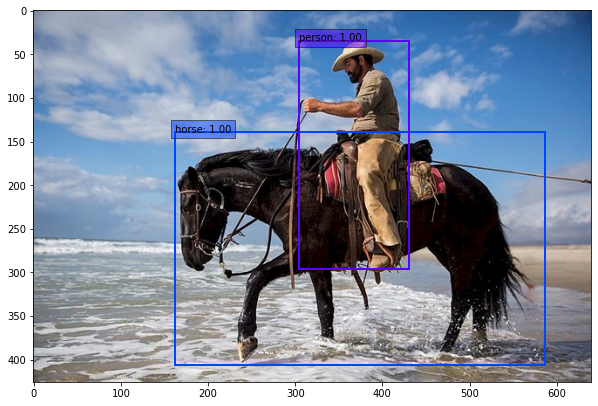

In [51]:
from utils.ssd_predict_show import SSDPredictShow

# 파일 경로
image_file_path = "./data/cowboy-757575_640.jpg"


# 예측 및 예측 결과를 이미지로 출력
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)